In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import os
%matplotlib inline
from PIL import Image
import re
import glob
from datetime import datetime as dt
import math

## Watershed 3 Time Series
- February 2019 to December 2019

In [ ]:
# folder of all images in W3 from 2/2019-12/2019
w3_image_list = glob.glob("img_folder/*.JPG")

In [2]:
# read merged.csv a file which have all pixel information(see data preparation in ml_model.ipynb)
merged = pd.read_csv("merged.csv")

In [ ]:
# extract path to all image files
sel_folder = sorted(w3_image_list, key = lambda l:l.split("\\")[-1])
# create a new data frame for image files in this folder(make temperature column)
dic = {}
for im in sel_folder:
    dic[im.split("\\")[-1]] = extract_temperature(im)
temp = pd.DataFrame(dic.items(), columns = ["orig_name", "temperature"])
temp.temperature=temp.temperature.apply(lambda a:a[:2])
temp["date"] = temp.orig_name.apply(lambda a: a.split("_")[2])
temp.date = temp.date.apply(lambda a: dt.strptime(a, '%Y%m%d').strftime('%m/%d/%Y'))
temp["time"] =temp.orig_name.apply(lambda a: a.split("_")[-1][:-4])
temp.time = temp.time.apply(lambda a: a[:2]+":"+a[2:4]+":"+a[4:])

Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)
temp.date = pd.to_datetime(temp.date)
# temp.time = pd.to_datetime(temp.time)
temp["year"] = temp.date.dt.year
temp["week"] =temp.date.dt.isocalendar().week
temp["month"] = temp.date.dt.month
temp["season"] = temp.date.apply(lambda x: get_season(x))
temp = pd.get_dummies(temp, columns=["season"], prefix=["season"] )
# sample data set of w3 folder with features collected
temp.to_csv("w3_image_temp.csv", index=False)

In [5]:
temp.head()

,orig_name,temperature,date,time,year,week,month,season_autumn,season_spring,season_summer,season_winter
0,Hbwtr_w3_20190205_115836.JPG,46,2019-02-05,11:58:36,2019,6,2,0,0,0,1
1,Hbwtr_w3_20190206_115835.JPG,37,2019-02-06,11:58:35,2019,6,2,0,0,0,1
2,Hbwtr_w3_20190207_120335.JPG,35,2019-02-07,12:03:35,2019,6,2,0,0,0,1
3,Hbwtr_w3_20190208_115835.JPG,39,2019-02-08,11:58:35,2019,6,2,0,0,0,1
4,Hbwtr_w3_20190208_120335.JPG,39,2019-02-08,12:03:35,2019,6,2,0,0,0,1


In [4]:
# extract image np.array for each and save in image_dict
image_dict = {}
def my_func(row):
    if row["orig_name"] in image_dict:
        return
    path =  "img_folder/invert_"+row["orig_name"]
    img= np.asarray(Image.open(path))
    image_dict[row["orig_name"]] = img
_ = temp.apply(lambda c: my_func(c),axis=1)

In [3]:
# load ml model
from joblib import dump, load
model= load("model.joblib")
# list of classes that are snow-like
snow_like = ['snow_o',
 'ice_t',
 'snow_t',
 'ice_o']

In [15]:
# sample every other five dates
temp_sample = temp.set_index("month").iloc[::5,:]
temp_sample["%_snow_ice_cover"] = np.nan
temp_sample.reset_index().to_csv("test_timeseries_sample.csv", index=False)

In [ ]:
# save copy to update csv
temp_up  = temp.copy()

In [ ]:
for index, row in temp.iloc[51:].iterrows():
    try:
        # print("Start index:", index)
        filename= row.orig_name
        img = image_dict[filename]
        ind =np.where((img[:,:,0]!=0) & (img[:,:,1]!=0) & (img[:,:,2]!=0))
        y_vals = ind[0]
        x_vals = ind[1]
        _= img[y_vals,x_vals,:]
        r_vals, g_vals, b_vals = _[:,0], _[:,1], _[:,2]
        point = pd.DataFrame({'x': x_vals,
         'y': y_vals,
         'R': r_vals,
         'G': g_vals,
         'B': b_vals,
        })
        point['temperature']= row.temperature
        point['year']= row.year
        point['week']= row.week
        point['month']= row.month
        point['season_autumn']= row.season_autumn
        point['season_spring']= row.season_spring
        point['season_winter']= row.season_winter
        point["predict"] = model.predict(point)
        total_snow_like = point[point.predict.isin(snow_like)].shape[0]
        total_pixels = point.shape[0]
        temp_up.loc[index,"%_snow_ice_cover"] = total_snow_like/total_pixels
        temp_up.to_csv("time_series_updated.csv", index=False)
        # print("Finished at index:", index)
    except:
        # print("Error at index:", index)
        continue

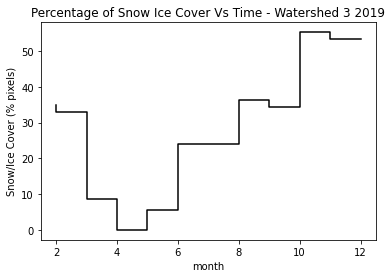

In [26]:
temp_sample["percentage"] = temp_sample["%_snow_ice_cover"]*100
_ = temp_sample.groupby("month").mean()
sns.lineplot(x = "month", y= "percentage", data = _,drawstyle='steps-pre', color = "k")
plt.title("Percentage of Snow Ice Cover Vs Time - Watershed 3 2019")
plt.ylabel("Snow/Ice Cover (% pixels)");

## Watershed 6 Time Series
 - October 2018 to April 2019

Create a dataframe input for model prediction using the image files

In [5]:
w6_image_list = glob.glob("w6_roi_image/*.JPG")
w6_orig_name= [w[20:] for w in w6_image_list] #change code here according to local path
# select w6 temp info from merged csv
w6_merged = merged[merged.watershed=="w6"]
date_temp_w6  = w6_merged[(w6_merged.orig_name.isin(w6_orig_name))].drop_duplicates(subset=["orig_name", "temperature"])
date_temp_w6.sort_values(by="orig_name", inplace=True)
date_temp_w6 = date_temp_w6.reset_index()[
    ["orig_name", "temperature","year", "week", "month", "season_autumn","season_spring", "season_winter" ]]
date_temp_w6

,orig_name,temperature,year,week,month,season_autumn,season_spring,season_winter
0,Hbwtr_w6_20181013_120459.JPG,40.0,2018,41,10,1,0,0
1,Hbwtr_w6_20181014_120456.JPG,50.0,2018,41,10,1,0,0
2,Hbwtr_w6_20181015_115953.JPG,50.0,2018,42,10,1,0,0
3,Hbwtr_w6_20181016_120450.JPG,50.0,2018,42,10,1,0,0
4,Hbwtr_w6_20181017_115947.JPG,50.0,2018,42,10,1,0,0
...,...,...,...,...,...,...,...,...
192,Hbwtr_w6_20190423_120119.JPG,50.0,2019,17,4,0,1,0
193,Hbwtr_w6_20190424_120119.JPG,51.0,2019,17,4,0,1,0
194,Hbwtr_w6_20190425_120119.JPG,55.0,2019,17,4,0,1,0
195,Hbwtr_w6_20190426_120119.JPG,42.0,2019,17,4,0,1,0


In [6]:
# sample every other five dates
w6_temp_sample = date_temp_w6.set_index("month").iloc[::5,:]
w6_temp_sample["%_snow_ice_cover"] = np.nan
w6_temp_sample.reset_index(inplace=True)
w6_temp_sample.to_csv("w6_time_series.csv", index=False)

In [7]:
# # extract image np.array for each and save in image_dict
w6_image_dict = {}
def my_func(row):
    if row["orig_name"] in w6_image_dict:
        return
    path =  "w6_roi_image/invert_"+row["orig_name"]
    img= np.asarray(Image.open(path))
    w6_image_dict[row["orig_name"]] = img
_ = w6_temp_sample.apply(lambda c: my_func(c),axis=1)

In [8]:
w6_temp_sample.head()

,month,orig_name,temperature,year,week,season_autumn,season_spring,season_winter,%_snow_ice_cover
0,10,Hbwtr_w6_20181013_120459.JPG,40.0,2018,41,1,0,0,NaN
1,10,Hbwtr_w6_20181018_120443.JPG,50.0,2018,42,1,0,0,NaN
2,10,Hbwtr_w6_20181023_115928.JPG,42.0,2018,43,1,0,0,NaN
3,10,Hbwtr_w6_20181028_115912.JPG,39.0,2018,43,1,0,0,NaN
4,11,Hbwtr_w6_20181102_115856.JPG,30.0,2018,44,1,0,0,NaN


In [ ]:
for index, row in w6_temp_sample.iterrows():
    try:
        # print("Start index:", index)
        if not math.isnan(row["%_snow_ice_cover"]):
            # print("Already found at index:", index)
            continue
        # if row.temperature>=41:
        #     print("Temperature larger than 41 F, snow_cover = 0"
        filename= row.orig_name
        img = w6_image_dict[filename]
        ind =np.where((img[:,:,0]!=0) & (img[:,:,1]!=0) & (img[:,:,2]!=0))
        y_vals = ind[0]
        x_vals = ind[1]
        _= img[y_vals,x_vals,:]
        r_vals, g_vals, b_vals = _[:,0], _[:,1], _[:,2]
        point = pd.DataFrame({'x': x_vals,
         'y': y_vals,
         'R': r_vals,
         'G': g_vals,
         'B': b_vals,
        })
        point['temperature']= row.temperature
        point['year']= row.year
        point['week']= row.week
        point['month']= row.month
        point['season_autumn']= row.season_autumn
        point['season_spring']= row.season_spring
        point['season_winter']= row.season_winter
        point["predict"] = model.predict(point)
        
        total_snow_like = point[point.predict.isin(snow_like)].shape[0]
        total_pixels = point.shape[0]
        w6_temp_sample.loc[index,"%_snow_ice_cover"] = total_snow_like/total_pixels
        w6_temp_sample.to_csv("w6_time_series.csv", index=False)
        # print("Finished at index:", index)
    except:
        # print("Error at index:", index)
        continue

In [4]:
w6_temp_sample["percentage"] = w6_temp_sample["%_snow_ice_cover"]*100
w6_temp_sample

,month,orig_name,temperature,year,week,season_autumn,season_spring,season_winter,%_snow_ice_cover,percentage
0,10,Hbwtr_w6_20181013_120459.JPG,40.0,2018,41,1,0,0,0.000000,0.000000
1,10,Hbwtr_w6_20181018_120443.JPG,50.0,2018,42,1,0,0,0.000000,0.000000
2,10,Hbwtr_w6_20181023_115928.JPG,42.0,2018,43,1,0,0,0.000000,0.000000
3,10,Hbwtr_w6_20181028_115912.JPG,39.0,2018,43,1,0,0,0.000000,0.000000
4,11,Hbwtr_w6_20181102_115856.JPG,30.0,2018,44,1,0,0,0.000005,0.000480
5,11,Hbwtr_w6_20181107_115840.JPG,31.0,2018,45,1,0,0,0.005763,0.576297
6,11,Hbwtr_w6_20181112_115824.JPG,46.0,2018,46,1,0,0,0.000106,0.010565
7,11,Hbwtr_w6_20181117_120308.JPG,37.0,2018,46,1,0,0,0.007572,0.757237
8,11,Hbwtr_w6_20181121_115956.JPG,28.0,2018,47,1,0,0,0.001804,0.180380
9,11,Hbwtr_w6_20181126_115940.JPG,33.0,2018,48,1,0,0,0.000365,0.036526


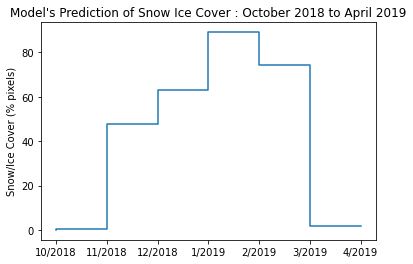

In [16]:
 _ = w6_temp_sample.groupby(["month","year"]).mean()
_.index = ['{}/{}'.format(month, year) for month, year in _.index]
_.sort_index(key=lambda x: x.str.split("/").str[-1], inplace=True)
sns.lineplot(x = _.index, y= _.percentage,drawstyle='steps-pre')
plt.title("Model's Prediction of Snow Ice Cover : October 2018 to April 2019")
plt.ylabel("Snow/Ice Cover (% pixels)");